In [1]:
debug = False
n_rows_debug = 100000

In [2]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import math
import collections
import time
from copy import deepcopy
import seaborn as sns
import os, gc
from tqdm import tqdm
import re

from statsmodels.graphics.tsaplots import plot_acf

""" SCIKIT-LEARN """
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix, accuracy_score, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from collections import Counter, defaultdict

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import joblib

pd.set_option('display.float_format', lambda x: '%.5f' % x) # No scientic notation
pd.set_option('display.max_columns', 100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [3]:
import polars as pl

def timestamp_UTC_conversion(train, date_col) :
    """  """
    
    # To avoid bugs
    if date_col == 'date' :
        train = train.rename(columns = {'date' : 'date_'})
        date_col = 'date_'
            
    # Transform
    dt_transforms = [
                     #pl.col(date_col).str.to_datetime(time_zone='UTC'), # UTC conversion to avoid different timezones
                     (pl.col(date_col).str.to_datetime().dt.date()).alias('date'), #  Extract date
                     pl.col(date_col).str.to_datetime().dt.time().alias('time'), # Extract time
                    ]

    # Apply transform
    return  (pl.from_pandas(train)
               .with_columns((dt_transforms))
               .to_pandas()
            )

In [4]:
def process_date(train, date_col, prefixe = '', extract_features = False) :
    
    # Force to str (to avoid datetime error)
    train[date_col] = train[date_col].astype(str)
                
    # Polar UTC conversion
    train = timestamp_UTC_conversion(train, date_col)
    
    # Convert to string
    train['date'] = train['date'].astype(str)
    train['time'] = train['time'].astype(str)
    train[date_col] = train['date'] + ' ' + train['time']
    
    # -----------------------------------------------------
    # FEATURES EXTRACTION
    
    # Return
    if not(extract_features) :
        return train
    
    # Date features
    train['year']  = (train['date'].apply(lambda x : x[:4]).astype(int)).astype(int)
    train['month'] = train['date'].apply(lambda x : x[5:7]).astype(int)
    train['day']   = train['date'].apply(lambda x : x[8:10]).astype(int)
    
    # Day of week
    train['dayofweek'] = train[['year', 'month', 'day']].apply(lambda row : datetime(row['year'], row['month'], row['day']).weekday(), axis=1)
    
    # Time features
    train['hour']    = train['time'].apply(lambda x : x[:2]).astype(int)
    train['minutes'] = train['time'].apply(lambda x : x[3:5]).astype(int)
    train['seconds'] = train['time'].apply(lambda x : x[6:7]).astype(int)
    
    # Rename
    if len(prefixe) > 0 :
        cols = ['year', 'month', 'day', 'hour', 'minutes', 'seconds']
        train = train.rename(columns = {k : f"{prefixe}_{k}" for k in cols})

    # Drop column
    #train.drop(columns = [date_col], inplace=True)
    
    # Return
    return train

In [5]:
def reduce_memory_usage(df, print_info=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    
    if print_info :
        print('*'*50)
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory before : {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    if print_info :
        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory after  : {:.2f} MB'.format(end_mem))
        print('Decreased by  : {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('*'*50 + '\n')
    
    return df

In [6]:
train = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/train.csv")
if debug :
    print("DEBUG IS ON !")
    train = train.sample(n=n_rows_debug, random_state=12)

# Show
print(train.shape)
train.head(2)

(2018352, 9)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0


In [7]:
# Pivot the training data to have a cleaner DataFrame where we can analyze the mean target values
# organized by datetime and various categorical variables.
pivot_train = train.pivot_table(index='datetime',columns=['county','product_type','is_business','is_consumption'], values='target', aggfunc='mean')

# Renaming columns for easier access and interpretation
pivot_train.columns = ['county{}_productType{}_isBusiness{}_isConsumption{}'.format(*col) for col in pivot_train.columns.values]
pivot_train.index = pd.to_datetime(pivot_train.index)
pivot_train.head(2)

,county0_productType0_isBusiness1_isConsumption0,county0_productType0_isBusiness1_isConsumption1,county0_productType1_isBusiness0_isConsumption0,county0_productType1_isBusiness0_isConsumption1,county0_productType1_isBusiness1_isConsumption0,county0_productType1_isBusiness1_isConsumption1,county0_productType2_isBusiness0_isConsumption0,county0_productType2_isBusiness0_isConsumption1,county0_productType2_isBusiness1_isConsumption0,county0_productType2_isBusiness1_isConsumption1,county0_productType3_isBusiness0_isConsumption0,county0_productType3_isBusiness0_isConsumption1,county0_productType3_isBusiness1_isConsumption0,county0_productType3_isBusiness1_isConsumption1,county1_productType1_isBusiness0_isConsumption0,county1_productType1_isBusiness0_isConsumption1,county1_productType3_isBusiness0_isConsumption0,county1_productType3_isBusiness0_isConsumption1,county1_productType3_isBusiness1_isConsumption0,county1_productType3_isBusiness1_isConsumption1,county2_productType1_isBusiness0_isConsumption0,county2_productType1_isBusiness0_isConsumption1,county2_productType1_isBusiness1_isConsumption0,county2_productType1_isBusiness1_isConsumption1,county2_productType3_isBusiness0_isConsumption0,county2_productType3_isBusiness0_isConsumption1,county2_productType3_isBusiness1_isConsumption0,county2_productType3_isBusiness1_isConsumption1,county3_productType1_isBusiness0_isConsumption0,county3_productType1_isBusiness0_isConsumption1,county3_productType1_isBusiness1_isConsumption0,county3_productType1_isBusiness1_isConsumption1,county3_productType3_isBusiness0_isConsumption0,county3_productType3_isBusiness0_isConsumption1,county3_productType3_isBusiness1_isConsumption0,county3_productType3_isBusiness1_isConsumption1,county4_productType0_isBusiness1_isConsumption0,county4_productType0_isBusiness1_isConsumption1,county4_productType1_isBusiness0_isConsumption0,county4_productType1_isBusiness0_isConsumption1,county4_productType1_isBusiness1_isConsumption0,county4_productType1_isBusiness1_isConsumption1,county4_productType3_isBusiness0_isConsumption0,county4_productType3_isBusiness0_isConsumption1,county4_productType3_isBusiness1_isConsumption0,county4_productType3_isBusiness1_isConsumption1,county5_productType0_isBusiness1_isConsumption0,county5_productType0_isBusiness1_isConsumption1,county5_productType1_isBusiness0_isConsumption0,county5_productType1_isBusiness0_isConsumption1,...,county10_productType2_isBusiness1_isConsumption0,county10_productType2_isBusiness1_isConsumption1,county10_productType3_isBusiness0_isConsumption0,county10_productType3_isBusiness0_isConsumption1,county10_productType3_isBusiness1_isConsumption0,county10_productType3_isBusiness1_isConsumption1,county11_productType0_isBusiness1_isConsumption0,county11_productType0_isBusiness1_isConsumption1,county11_productType1_isBusiness0_isConsumption0,county11_productType1_isBusiness0_isConsumption1,county11_productType1_isBusiness1_isConsumption0,county11_productType1_isBusiness1_isConsumption1,county11_productType2_isBusiness0_isConsumption0,county11_productType2_isBusiness0_isConsumption1,county11_productType2_isBusiness1_isConsumption0,county11_productType2_isBusiness1_isConsumption1,county11_productType3_isBusiness0_isConsumption0,county11_productType3_isBusiness0_isConsumption1,county11_productType3_isBusiness1_isConsumption0,county11_productType3_isBusiness1_isConsumption1,county12_productType3_isBusiness1_isConsumption0,county12_productType3_isBusiness1_isConsumption1,county13_productType1_isBusiness0_isConsumption0,county13_productType1_isBusiness0_isConsumption1,county13_productType1_isBusiness1_isConsumption0,county13_productType1_isBusiness1_isConsumption1,county13_productType3_isBusiness0_isConsumption0,county13_productType3_isBusiness0_isConsumption1,county13_productType3_isBusiness1_isConsumption0,county13_productType3_isBusiness1_isConsumption1,county14_productType1_isBusiness0_isConsumption0,county14_productType1_isBusiness0_isConsumption1,county14_productType1_isBus

<Axes: xlabel='datetime'>

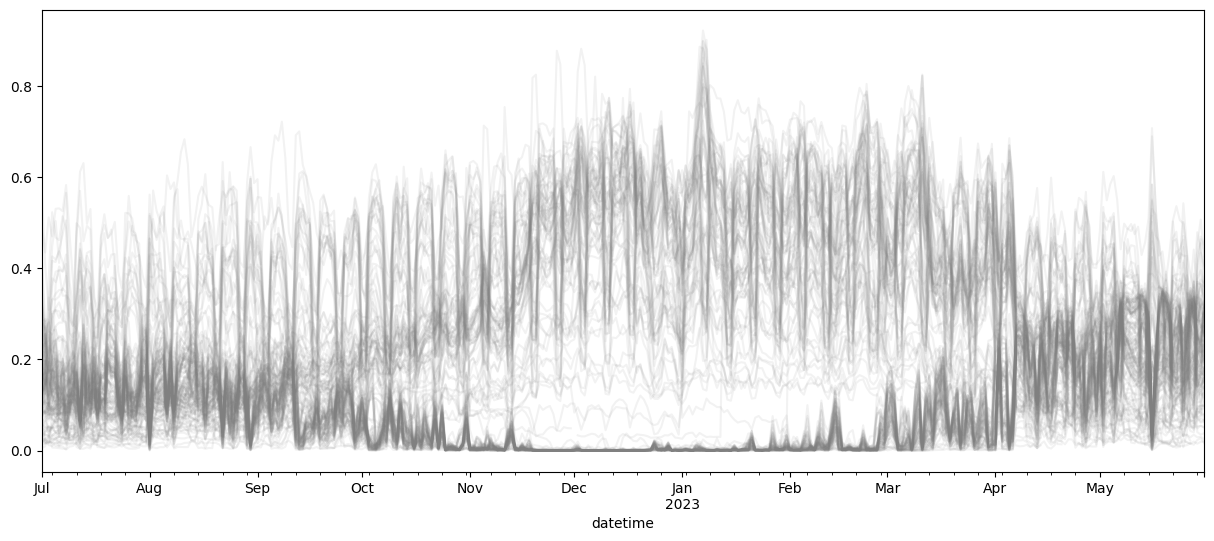

In [8]:
df_plot = pivot_train.copy()
df_plot = (df_plot - df_plot.min())/(df_plot.max() - df_plot.min())
df_plot_resampled_D = df_plot.resample('D').mean()

# Plot the consumption data with alpha=0.1 
df_plot_resampled_D.loc['2022-7':].plot(alpha=0.1, color='gray', figsize=(15, 6), legend=False)

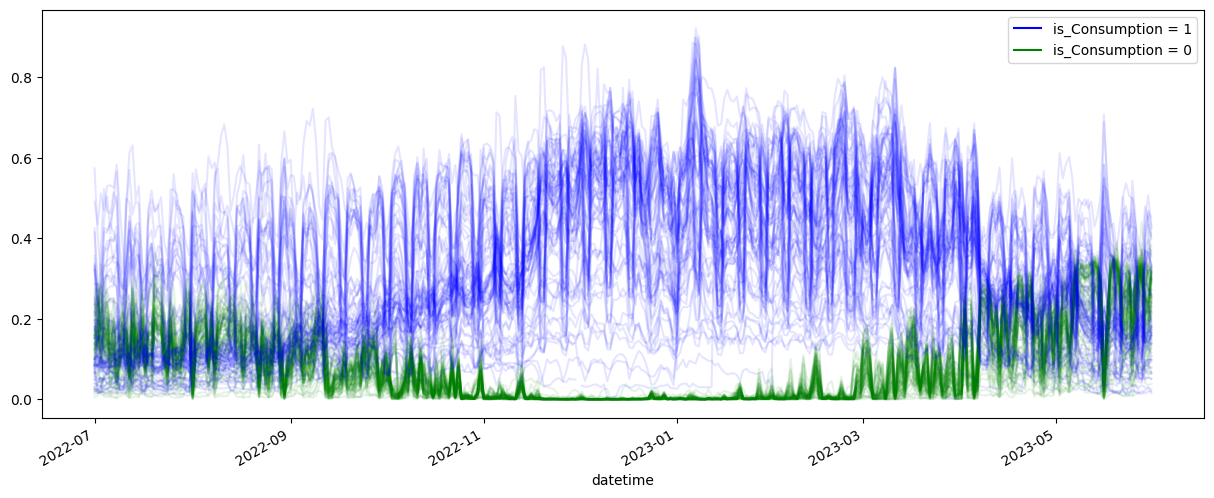

In [9]:
# Select the relevant columns and time range
columns_consumption_0 = df_plot_resampled_D.columns[df_plot_resampled_D.columns.str.contains('isConsumption0')]
columns_consumption_1 = df_plot_resampled_D.columns[df_plot_resampled_D.columns.str.contains('isConsumption1')]

# Create a single legend for each category
plt.figure(figsize=(15, 6))
plt.plot([], color='blue', label='is_Consumption = 1')
plt.plot([], color='green', label='is_Consumption = 0')
plt.legend()

# Plot the data for is_Consumption = 0 in green
for column in columns_consumption_0:
    df_plot_resampled_D.loc['2022-7':, column].plot(alpha=0.1, color='green', legend=False)

# Plot the data for is_Consumption = 1 in blue
for column in columns_consumption_1:
    df_plot_resampled_D.loc['2022-7':, column].plot(alpha=0.1, color='blue', legend=False)

# Add a single legend to the plot
#plt.legend()

# Show the plot
plt.show()

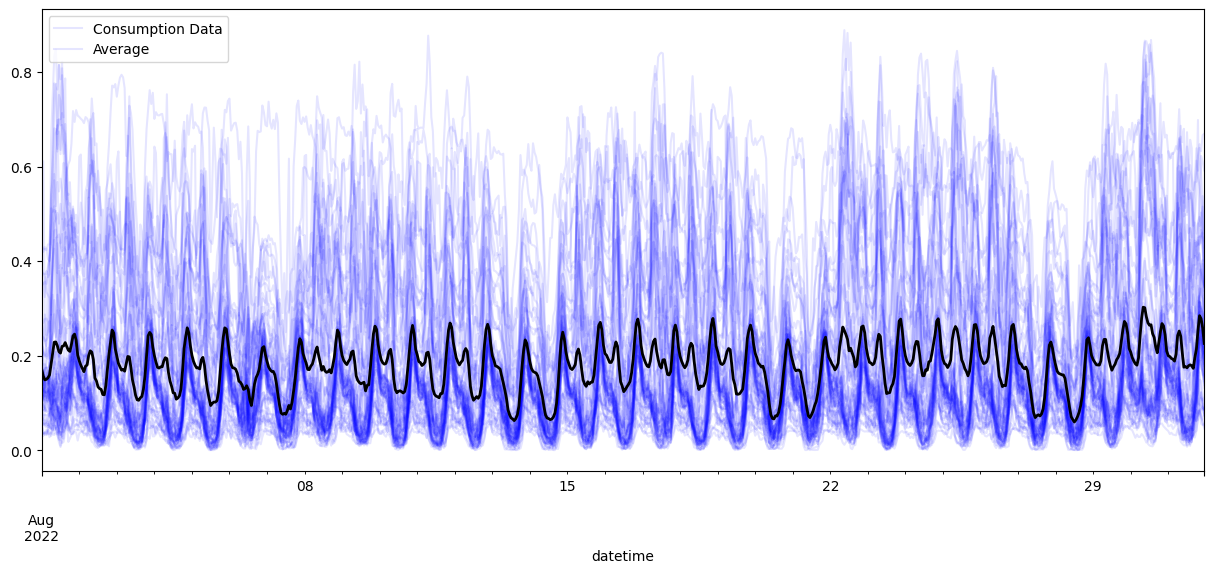

In [10]:
# Select the consumption_1 data
consumption_1 = df_plot.loc[:, df_plot.columns.str.contains('isConsumption1')]

# Filter the data for the desired time period ('2023-5' onwards)
consumption_1_filtered = consumption_1.loc['2022-8']

# Calculate the average values
average_values = consumption_1_filtered.mean(axis=1)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the consumption data with alpha=0.1 in blue
consumption_1_filtered.plot(alpha=0.1, color='blue', ax=ax)

# Plot the average values as a black bold line
average_values.plot(color='black', linewidth=2, ax=ax)

# Set the legend
ax.legend(['Consumption Data', 'Average'])

# Show the plot
plt.show()

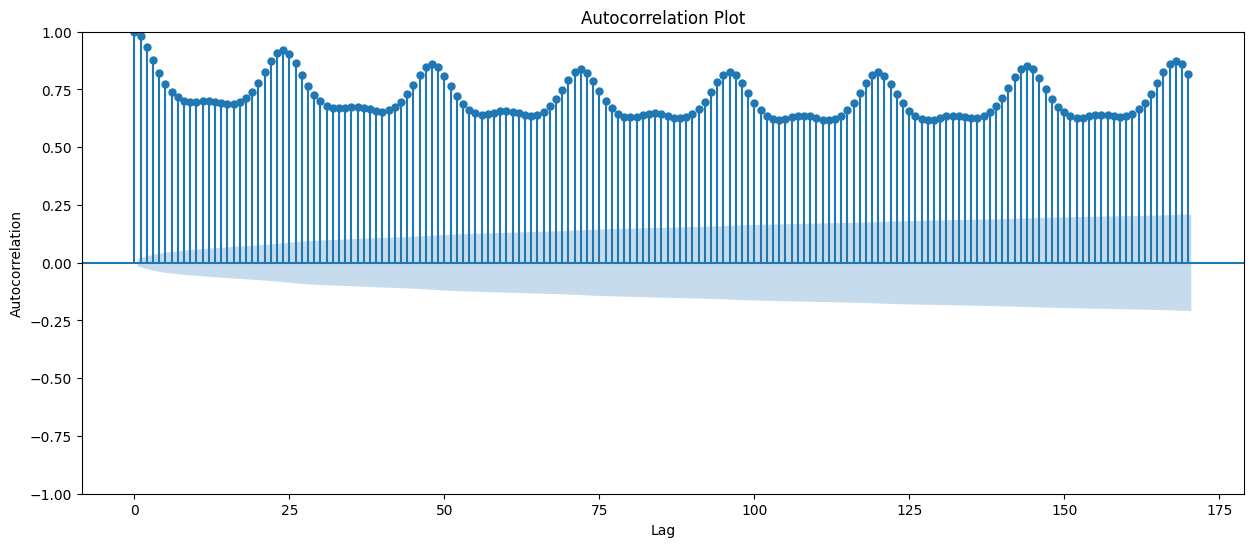

In [11]:
# Calculate the average values
average_values = consumption_1.mean(axis=1)

# Create a figure and axis with figsize
fig, ax = plt.subplots(figsize=(15, 6))

# Calculate and plot the autocorrelation
plot_acf(average_values, lags=170, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

In [12]:
%%time

# Date processing + features extraction
for date_col in ['datetime'] :
    train = process_date(train, date_col, extract_features = True)

# Show
print(train.shape)
train.head(2)

(2018352, 18)
CPU times: user 51.7 s, sys: 940 ms, total: 52.6 s
Wall time: 51.4 s


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0


In [13]:
# Print datetimes in the train dataset (2021-09-01 -> 2023-05-31)
train['datetime'].value_counts().to_frame().sort_index()

,count
datetime,
2021-09-01 00:00:00,122
2021-09-01 01:00:00,122
2021-09-01 02:00:00,122
2021-09-01 03:00:00,122
2021-09-01 04:00:00,122
...,...
2023-05-31 19:00:00,130
2023-05-31 20:00:00,130
2023-05-31 21:00:00,130


count   2017824.00000
mean        274.85556
std         909.50238
min           0.00000
25%           0.37800
50%          31.13300
75%         180.20625
max       15480.27400
Name: target, dtype: float64

<Axes: >

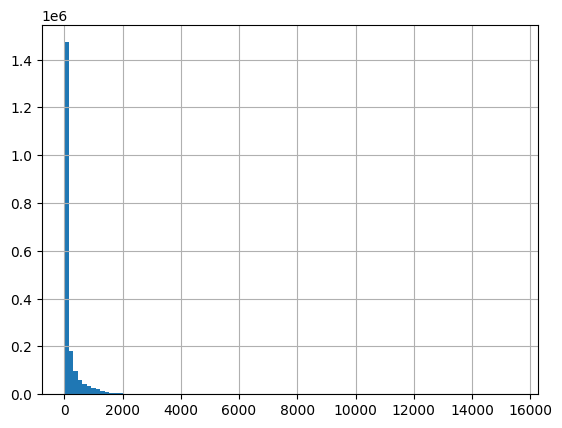

In [14]:
# Show target distribution
display(train['target'].describe())
train['target'].hist(bins=100)

In [15]:
for day_shift in range(2, 8) :

    # Add previous targets
    train['data_block_id_shifted'] = train['data_block_id'] + day_shift
    train = pd.merge(train,
                     train[["county", "is_business", "product_type", "is_consumption", "time", "data_block_id_shifted", "target"]].rename(columns = {"data_block_id_shifted":"data_block_id",
                                                                                                                                                     "target" : f"target_revealed_{day_shift}days_ago",
                                                                                                                                                    }),
                     how = 'left',
                     on = ["county", "is_business", "product_type", "is_consumption", "time", "data_block_id"],
                    )

    # Fill NaN with -1
    mask = train[f"target_revealed_{day_shift}days_ago"].isna()
    train.loc[mask, f"target_revealed_{day_shift}days_ago"] = train.loc[mask, "target"]

# Drop useless column
train.drop(columns = ['data_block_id_shifted'], inplace=True)

# Show
print(train.shape)
train.tail(2)

(2018352, 24)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago
2018350,15,1,3,0.00000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,23:00:00,2023,5,31,2,23,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018351,15,1,3,196.24000,1,2023-05-31 23:00:00,637,2018351,60,2023-05-31,23:00:00,2023,5,31,2,23,0,0,177.05600,161.65000,183.75600,189.93300,188.68900,195.70700


In [16]:
county = 15
is_business = 1
product_type = 3
is_consumption = 1

In [17]:
df = train.copy()

# Show
print(df.shape)
df.head(2)

(2018352, 24)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000


In [18]:
electricity_prices = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv")

# Date processing + features extraction
for date_col in ['forecast_date', 'origin_date'] :
    electricity_prices = process_date(electricity_prices, date_col)
    
# Show
print(electricity_prices.shape)
electricity_prices.head(2)

(15286, 6)


,forecast_date,euros_per_mwh,origin_date,data_block_id,date,time
0,2021-09-01 00:00:00,92.51000,2021-08-31 00:00:00,1,2021-08-31,00:00:00
1,2021-09-01 01:00:00,88.90000,2021-08-31 01:00:00,1,2021-08-31,01:00:00


In [19]:
%%time

# Shift data_clock_id (during the submission phase, the data are available 2 days ago)
electricity_prices['data_block_id_shifted'] = electricity_prices['data_block_id'] + 2

# Join
df = pd.merge(df,
              electricity_prices[["time", "data_block_id_shifted", "euros_per_mwh"]].rename(columns = {"data_block_id_shifted":"data_block_id"}),
              how = 'left',
              on = ["time", "data_block_id"],
             )

# Show
print(df.shape)
df.head(2)

(2018352, 25)
CPU times: user 609 ms, sys: 81.1 ms, total: 690 ms
Wall time: 687 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN


In [20]:
gas_prices = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv")

# Date processing + features extraction
for date_col in ['forecast_date', 'origin_date'] :
    gas_prices = process_date(gas_prices, date_col)
    
# Show
print(gas_prices.shape)
gas_prices.head(2)

(637, 7)


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,date,time
0,2021-09-01 00:00:00,45.23000,46.32000,2021-08-31 00:00:00,1,2021-08-31,00:00:00
1,2021-09-02 00:00:00,45.62000,46.29000,2021-09-01 00:00:00,2,2021-09-01,00:00:00


In [21]:
%%time

# Shift data_clock_id (during the submission phase, the data are available 2 days ago)
gas_prices['data_block_id_shifted'] = gas_prices['data_block_id'] + 2

# Join
cols = ['data_block_id_shifted', 'time', 'lowest_price_per_mwh', 'highest_price_per_mwh']
df = df.merge(gas_prices[cols].rename(columns = {'data_block_id_shifted' : 'data_block_id'}),
             how='left',
             on=["time", "data_block_id"],
             )

# Show
print(df.shape)
df.head(2)

(2018352, 27)
CPU times: user 635 ms, sys: 145 ms, total: 780 ms
Wall time: 774 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN,NaN,NaN


In [22]:
client = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/client.csv")

# Rename
client = client.rename(columns = {'date' : 'datetime'})

# Date processing + features extraction
for date_col in ['datetime'] :
    client = process_date(client, date_col)
    
# Fill NaN
client.fillna(0, inplace=True)

# Show
print(client.shape)
client.head(2)

(41919, 9)


,product_type,county,eic_count,installed_capacity,is_business,datetime,data_block_id,date,time
0,1,0,108,952.89000,0,2021-09-01 00:00:00,2,2021-09-01,00:00:00
1,2,0,17,166.40000,0,2021-09-01 00:00:00,2,2021-09-01,00:00:00


In [23]:
%%time

# Shift data_clock_id (during the submission phase, the data are available 2 days ago)
client['data_block_id_shifted'] = client['data_block_id'] + 2

# Join
df = df.merge(client.drop(columns = ['date', 'datetime', 'data_block_id', 'time']).rename(columns = {'data_block_id_shifted' : 'data_block_id'}),
             how='left',
             on=['data_block_id', 'county', 'is_business', 'product_type'], # don't merge on time ! Client data are only available at 00:00:00
             )

# Show
print(df.shape)
df.head(2)

(2018352, 29)
CPU times: user 401 ms, sys: 148 ms, total: 550 ms
Wall time: 547 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN,NaN,NaN,NaN,NaN


In [24]:
location = pd.read_csv("/kaggle/input/fabiendaniels-mapping-locations-and-county-codes/county_lon_lats.csv").drop(columns = ["Unnamed: 0"])

# Convert to int to avoid float imprecision
for k in ['latitude', 'longitude'] :
    location[k] = (10*location[k]).astype(int)

# Show
print(location.shape)
location.head(2)

(75, 3)


,county,longitude,latitude
0,0,242,591
1,0,252,591


In [25]:
def process_weather_info(h, location=location) :
    
    # Drop duplicates
    h = h.drop_duplicates().reset_index(drop=True)

    # Convert to int to avoid float imprecision
    for k in ['latitude', 'longitude'] :
        h[k] = (10*h[k]).astype(int)
    
    # Add location
    h = pd.merge(h, location, how='left', on=['latitude', 'longitude'])
    
    # Fill NaN and force int
    h['county'] = h['county'].fillna(-1).astype(int)

    # Return
    return h

In [26]:
%%time

historical_weather = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv")

# Date processing + features extraction
for date_col in ['datetime'] :
    historical_weather = process_date(historical_weather, date_col)
    
# Reduce memory usage to avoid OOM (Out OF Memory error)
#historical_weather = reduce_memory_usage(historical_weather, print_info=True)

# Show
print(historical_weather.shape)
historical_weather.head(2)

(1710800, 20)
CPU times: user 9.67 s, sys: 799 ms, total: 10.5 s
Wall time: 10.6 s


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,date,time
0,2021-09-01 00:00:00,14.40000,12.00000,0.00000,0.00000,1015.80000,4,4,0,0,6.69444,3,0.00000,0.00000,0.00000,57.60000,21.70000,1,2021-09-01,00:00:00
1,2021-09-01 00:00:00,14.00000,12.00000,0.00000,0.00000,1010.60000,7,8,0,0,4.94444,353,0.00000,0.00000,0.00000,57.60000,22.20000,1,2021-09-01,00:00:00


In [27]:
# Add location
historical_weather = process_weather_info(historical_weather)

# Show
print(historical_weather.shape)
historical_weather.head(2)

(1710800, 21)


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,date,time,county
0,2021-09-01 00:00:00,14.40000,12.00000,0.00000,0.00000,1015.80000,4,4,0,0,6.69444,3,0.00000,0.00000,0.00000,576,217,1,2021-09-01,00:00:00,-1
1,2021-09-01 00:00:00,14.00000,12.00000,0.00000,0.00000,1010.60000,7,8,0,0,4.94444,353,0.00000,0.00000,0.00000,576,222,1,2021-09-01,00:00:00,-1


In [28]:
 #Aggregate information over latitude/longitude
dict_agg = {'temperature' : ['min', 'mean', 'max', 'std'],
            'dewpoint' : ['min', 'mean', 'max', 'std'],
            'rain' : ['min', 'mean', 'max', 'std'],
            'snowfall' : ['min', 'mean', 'max', 'std'],
            'surface_pressure' : ['min', 'mean', 'max', 'std'],
            'cloudcover_total' : ['min', 'mean', 'max', 'std'],
            'cloudcover_low' : ['min', 'mean', 'max', 'std'],
            'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
            'cloudcover_high' : ['min', 'mean', 'max', 'std'],
            'windspeed_10m' : ['min', 'mean', 'max', 'std'],
            'winddirection_10m' : ['min', 'mean', 'max', 'std'],
            'shortwave_radiation' : ['min', 'mean', 'max', 'std'],
            'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
            'diffuse_radiation' : ['min', 'mean', 'max', 'std'],
           }

# Groupby
keys = ['county', 'datetime']
historical_weather = historical_weather.groupby(keys).agg(dict_agg).reset_index()

# Flatten columns names
historical_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in historical_weather.columns]
historical_weather.columns = [x + '_h' if x not in keys else x for x in historical_weather.columns]

# Show
print(historical_weather.shape)
historical_weather.head(2)

(244400, 58)


,county,datetime,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_min_h,snowfall_mean_h,snowfall_max_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,cloudcover_total_mean_h,cloudcover_total_max_h,cloudcover_total_std_h,cloudcover_low_min_h,cloudcover_low_mean_h,cloudcover_low_max_h,cloudcover_low_std_h,cloudcover_mid_min_h,cloudcover_mid_mean_h,cloudcover_mid_max_h,cloudcover_mid_std_h,cloudcover_high_min_h,cloudcover_high_mean_h,cloudcover_high_max_h,cloudcover_high_std_h,windspeed_10m_min_h,windspeed_10m_mean_h,windspeed_10m_max_h,windspeed_10m_std_h,winddirection_10m_min_h,winddirection_10m_mean_h,winddirection_10m_max_h,winddirection_10m_std_h,shortwave_radiation_min_h,shortwave_radiation_mean_h,shortwave_radiation_max_h,shortwave_radiation_std_h,direct_solar_radiation_min_h,direct_solar_radiation_mean_h,direct_solar_radiation_max_h,direct_solar_radiation_std_h,diffuse_radiation_min_h,diffuse_radiation_mean_h,diffuse_radiation_max_h,diffuse_radiation_std_h
0,-1,2021-09-01 00:00:00,12.20000,13.94324,15.90000,0.95089,9.80000,11.49459,12.80000,0.74010,0.00000,0.05135,0.90000,0.19667,0.00000,0.00000,0.00000,0.00000,995.90000,1009.72432,1016.50000,5.54954,1,40.24324,100,39.97597,0,32.67568,100,38.74350,0,7.02703,96,22.14408,0,45.13514,100,40.99875,2.36111,5.23498,11.13889,2.49150,1,260.51351,360,148.58324,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-1,2021-09-01 01:00:00,11.70000,13.62973,15.70000,1.13256,9.40000,11.37297,12.90000,0.82214,0.00000,0.03784,0.80000,0.16219,0.00000,0.00000,0.00000,0.00000,996.00000,1009.86757,1016.80000,5.59082,1,42.59459,100,34.86439,0,34.40541,100,32.00821,0,7.48649,99,22.18310,0,40.81081,100,40.63512,2.50000,5.31532,10.75000,2.21529,2,317.24324,360,95.49706,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [29]:
%%time

# Shift datetime
historical_weather['datetime_shifted'] = (pd.to_datetime(historical_weather['datetime'].astype(str)) + pd.Timedelta(days=1, hours=13)).astype(str)

# Join
df = df.merge(historical_weather.drop(columns = ['datetime']).rename(columns = {'datetime_shifted' : 'datetime'}),
              how='left',
              on=['county', 'datetime'],
             )

# Show
print(df.shape)
df.head(2)

(2018352, 85)
CPU times: user 1.99 s, sys: 836 ms, total: 2.83 s
Wall time: 2.83 s


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_min_h,snowfall_mean_h,snowfall_max_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,cloudcover_total_mean_h,cloudcover_total_max_h,cloudcover_total_std_h,cloudcover_low_min_h,cloudcover_low_mean_h,cloudcover_low_max_h,cloudcover_low_std_h,cloudcover_mid_min_h,cloudcover_mid_mean_h,cloudcover_mid_max_h,cloudcover_mid_std_h,cloudcover_high_min_h,cloudcover_high_mean_h,cloudcover_high_max_h,cloudcover_high_std_h,windspeed_10m_min_h,windspeed_10m_mean_h,windspeed_10m_max_h,windspeed_10m_std_h,winddirection_10m_min_h,winddirection_10m_mean_h,winddirection_10m_max_h,winddirection_10m_std_h,shortwave_radiation_min_h,shortwave_radiation_mean_h,shortwave_radiation_max_h,shortwave_radiation_std_h,direct_solar_radiation_min_h,direct_solar_radiation_mean_h,direct_solar_radiation_max_h,direct_solar_radiation_std_h,diffuse_radiation_min_h,diffuse_radiation_mean_h,diffuse_radiation_max_h,diffuse_radiation_std_h
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
%%time

forecast_weather = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv")

# Date processing + features extraction
for date_col in ['forecast_datetime'] :
    forecast_weather = process_date(forecast_weather, date_col)

# Reduce memory usage to avoid OOM (Out OF Memory error)
#forecast_weather = reduce_memory_usage(forecast_weather, print_info=True)

# Show
print(forecast_weather.shape)
forecast_weather.head(2)

(3424512, 20)
CPU times: user 25 s, sys: 1.98 s, total: 27 s
Wall time: 32.2 s


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,date,time
0,57.60000,21.70000,2021-09-01 00:00:00+00:00,1,15.65579,11.55361,0.90482,0.01971,0.00000,0.90590,-0.41133,-9.10614,1,2021-09-01 01:00:00,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00
1,57.60000,22.20000,2021-09-01 00:00:00+00:00,1,13.00393,10.68984,0.88632,0.00446,0.00000,0.88666,0.20635,-5.35540,1,2021-09-01 01:00:00,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00


In [31]:
# Add location
forecast_weather = process_weather_info(forecast_weather)

# Show
print(forecast_weather.shape)
forecast_weather.head(2)

(3424512, 21)


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,date,time,county
0,576,217,2021-09-01 00:00:00+00:00,1,15.65579,11.55361,0.90482,0.01971,0.00000,0.90590,-0.41133,-9.10614,1,2021-09-01 01:00:00,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00,-1
1,576,222,2021-09-01 00:00:00+00:00,1,13.00393,10.68984,0.88632,0.00446,0.00000,0.88666,0.20635,-5.35540,1,2021-09-01 01:00:00,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00,-1


In [32]:
# Aggregate information over latitude/longitude
dict_agg = {'temperature' : ['min', 'mean', 'max', 'std'],
            'dewpoint' : ['min', 'mean', 'max', 'std'],
            'cloudcover_high' : ['min', 'mean', 'max', 'std'],
            'cloudcover_low' : ['min', 'mean', 'max', 'std'],
            'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
            'cloudcover_total' : ['min', 'mean', 'max', 'std'],
            '10_metre_u_wind_component' : ['min', 'mean', 'max', 'std'],
            '10_metre_v_wind_component' : ['min', 'mean', 'max', 'std'],
            'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
            'surface_solar_radiation_downwards' : ['min', 'mean', 'max', 'std'],
            'snowfall' : ['min', 'mean', 'max', 'std'],
            'total_precipitation' : ['min', 'mean', 'max', 'std'],
           }

# Groupby
keys = ['county', 'forecast_datetime']
forecast_weather = forecast_weather.groupby(keys).agg(dict_agg).reset_index()

# Flatten columns names
forecast_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in forecast_weather.columns]
forecast_weather.columns = [x + '_f' if x not in keys else x for x in forecast_weather.columns]

# Show
print(forecast_weather.shape)
forecast_weather.head(2)

(244992, 50)


,county,forecast_datetime,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_min_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_min_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,-1,2021-09-01 01:00:00,9.78323,13.16211,16.00356,2.00823,8.42336,11.01298,12.87869,1.14988,0.00000,0.36417,1.00000,0.35123,0.00012,0.12287,1.00000,0.17428,0.00000,0.04686,0.33823,0.07682,0.04475,0.44675,1.00000,0.30594,-0.41133,1.93854,4.01165,1.05230,-10.18109,-5.46869,-1.20770,2.91014,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-1,2021-09-01 02:00:00,9.82876,13.10870,15.79055,1.95895,8.59646,10.80204,12.21133,0.94485,0.00000,0.25805,0.98929,0.35229,0.00000,0.17831,0.90271,0.19737,0.00000,0.08839,0.36745,0.11410,0.00000,0.42780,0.99335,0.29959,0.08925,2.22432,4.42067,1.16239,-10.83990,-5.78760,-1.73053,3.03594,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000


In [33]:
%%time

# Join
df = df.merge(forecast_weather.rename(columns = {'forecast_datetime' : 'datetime'}),
              how='left',
              on=['county', 'datetime'],
             )

# Fill NaN
df = df.sort_values(by=['datetime']).reset_index(drop=True)
for k in df :
    if k.endswith('_f') :
        df[k] = df[k].ffill().bfill()

# Show
print(df.shape)
df.head(2)

(2018352, 133)
CPU times: user 6.84 s, sys: 2.34 s, total: 9.18 s
Wall time: 9.18 s


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_min_h,snowfall_mean_h,snowfall_max_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,...,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_min_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_min_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,11,0,2,7.62000,1,2021-09-01 00:00:00,0,89,44,2021-09-01,00:00:00,2021,9,1,2,0,0,0,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [34]:
# Sort
df = df.sort_values(by=['datetime']).reset_index(drop=True)

# Fill NaN
df.fillna(0, inplace=True)

# Show
print(df.shape)
df.head(2)

(2018352, 133)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_min_h,snowfall_mean_h,snowfall_max_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,...,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_min_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_min_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,7,1,3,0.00000,0,2021-09-01 00:00:00,0,60,30,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [35]:
del historical_weather, forecast_weather
_ = gc.collect()

In [36]:
def create_df(df, client, historical_weather, forecast_weather,
              electricity_prices, gas_prices, sample_prediction) :

    #################################################
    # ⚡ ELECTRICITY FEATURES ⚡
    #################################################

    # Join
    df = pd.merge(df,
                  electricity_prices[["time", "euros_per_mwh"]],
                  how = 'left',
                  on = ["time"],
                 )

    #################################################
    # 🛢️ GAS FEATURES 🛢️
    #################################################

    # Join
    cols = ['time', 'lowest_price_per_mwh', 'highest_price_per_mwh']
    df = df.merge(gas_prices[cols],
                 how='left',
                 on=["time"],
                 )

    #################################################
    # 🧑 CLIENT FEATURES 🧑
    #################################################
   
    # Join
    df = df.merge(client.drop(columns = ['datetime', 'date', 'time']),
                 how='left',
                 on=['county', 'is_business', 'product_type'],
                 )

    #################################################
    # 🌤️ HISTORICAL WEATHER FEATURES 🌤️
    #################################################
    
    # Aggregate information over latitude/longitude
    dict_agg = {'temperature' : ['min', 'mean', 'max', 'std'],
                'dewpoint' : ['min', 'mean', 'max', 'std'],
                'rain' : ['min', 'mean', 'max', 'std'],
                'snowfall' : ['min', 'mean', 'max', 'std'],
                'surface_pressure' : ['min', 'mean', 'max', 'std'],
                'cloudcover_total' : ['min', 'mean', 'max', 'std'],
                'cloudcover_low' : ['min', 'mean', 'max', 'std'],
                'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
                'cloudcover_high' : ['min', 'mean', 'max', 'std'],
                'windspeed_10m' : ['min', 'mean', 'max', 'std'],
                'winddirection_10m' : ['min', 'mean', 'max', 'std'],
                'shortwave_radiation' : ['min', 'mean', 'max', 'std'],
                'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
                'diffuse_radiation' : ['min', 'mean', 'max', 'std'],
               }

    # Groupby
    keys = ['county', 'datetime']
    historical_weather = historical_weather.groupby(keys).agg(dict_agg).reset_index()

    # Flatten columns names
    historical_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in historical_weather.columns]
    historical_weather.columns = [x + '_h' if x not in keys else x for x in historical_weather.columns]

    # Shift datetime
    historical_weather['datetime'] = (pd.to_datetime(historical_weather['datetime'].astype(str)) + pd.Timedelta(days=1, hours=13)).astype(str)
    
    # Join
    df = df.merge(historical_weather,
                  how='left',
                  on=['county', 'datetime'],
                 )
    
    #################################################
    # 🌤️ FORECAST WEATHER FEATURES 🌤️
    #################################################
    
    # Aggregate information over datetime
    dict_agg = {'temperature' : ['min', 'mean', 'max', 'std'],
                'dewpoint' : ['min', 'mean', 'max', 'std'],
                'cloudcover_high' : ['min', 'mean', 'max', 'std'],
                'cloudcover_low' : ['min', 'mean', 'max', 'std'],
                'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
                'cloudcover_total' : ['min', 'mean', 'max', 'std'],
                '10_metre_u_wind_component' : ['min', 'mean', 'max', 'std'],
                '10_metre_v_wind_component' : ['min', 'mean', 'max', 'std'],
                'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
                'surface_solar_radiation_downwards' : ['min', 'mean', 'max', 'std'],
                'snowfall' : ['min', 'mean', 'max', 'std'],
                'total_precipitation' : ['min', 'mean', 'max', 'std'],
               }

    # Groupby
    keys = ['county', 'forecast_datetime']
    forecast_weather = forecast_weather.groupby(keys).agg(dict_agg).reset_index()

    # Flatten columns names
    forecast_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in forecast_weather.columns]
    forecast_weather.columns = [x + '_f' if x not in keys else x for x in forecast_weather.columns]

    # Join
    df = df.merge(forecast_weather.rename(columns = {'forecast_datetime' : 'datetime'}),
                  how='left',
                  on=['county', 'datetime'],
                 )

    # Fill NaN
    df = df.sort_values(by=['datetime']).reset_index(drop=True)
    for k in df :
        if k.endswith('_f') :
            df[k] = df[k].ffill().bfill()
    
    #################################################
    # ⚙️ FINAL PROCESSING ⚙️
    #################################################
    
    # Sort
    #df = df.sort_values(by=['datetime']).reset_index(drop=True)

    # Fill NaN
    df.fillna(0, inplace=True)

    # Return
    return df

In [37]:
forbidden_cols = ['target',
                  'datetime',
                  'date',
                  'row_id',
                  'data_block_id',
                  'prediction_unit_id',
                  
                  # Useless feats
                  'minutes',
                  'snowfall_min_h',
                  'rain_min_h',
                  'seconds',
                  'highest_price_per_mwh',
                  'lowest_price_per_mwh',
                  'snowfall_max_h',
                  'snowfall_min_f',
                  'cloudcover_mid_min_f',
                  'cloudcover_high_min_f',
                 ]
numeric_cols   = df.select_dtypes(include=np.number).columns.tolist()

feats = [x for x in numeric_cols if x not in forbidden_cols]

print(f"{len(feats)} features.")
df[feats].head(1)

116 features.


,county,is_business,product_type,is_consumption,year,month,day,dayofweek,hour,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_mean_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,cloudcover_total_mean_h,cloudcover_total_max_h,cloudcover_total_std_h,cloudcover_low_min_h,cloudcover_low_mean_h,cloudcover_low_max_h,cloudcover_low_std_h,cloudcover_mid_min_h,cloudcover_mid_mean_h,cloudcover_mid_max_h,cloudcover_mid_std_h,cloudcover_high_min_h,cloudcover_high_mean_h,cloudcover_high_max_h,...,direct_solar_radiation_std_h,diffuse_radiation_min_h,diffuse_radiation_mean_h,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0,2021,9,1,2,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [38]:
# Fewer feats
if False :
    # Fewer feats
    feats = ['day',
             'month',
             'euros_per_mwh',
             'hour',
             'dayofweek',
             'county',
             'target_revealed_6days_ago',
             'target_revealed_5days_ago',
             'target_revealed_4days_ago',
             'target_revealed_3days_ago',
             'target_revealed_2days_ago',
             'year',
             'is_consumption',
             'is_business',
             'product_type',
             'eic_count',
             'installed_capacity',
             ]


print(f"{len(feats)} features.")
df[feats].head(1)

116 features.


,county,is_business,product_type,is_consumption,year,month,day,dayofweek,hour,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_mean_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,cloudcover_total_mean_h,cloudcover_total_max_h,cloudcover_total_std_h,cloudcover_low_min_h,cloudcover_low_mean_h,cloudcover_low_max_h,cloudcover_low_std_h,cloudcover_mid_min_h,cloudcover_mid_mean_h,cloudcover_mid_max_h,cloudcover_mid_std_h,cloudcover_high_min_h,cloudcover_high_mean_h,cloudcover_high_max_h,...,direct_solar_radiation_std_h,diffuse_radiation_min_h,diffuse_radiation_mean_h,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0,2021,9,1,2,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [39]:
lgbm_params = {'boosting_type': 'gbdt',
               'objective': 'regression',
               'metric' : 'mean_absolute_error',
               'importance_type': 'split',
               'learning_rate': 0.08,
               'n_estimators': 1000,
               'max_depth': -1,
               'min_child_samples': 120,
               'num_leaves': 250,
               'colsample_bytree': 0.85,
               'subsample': 0.85,
               'reg_alpha': 2,
               'reg_lambda': 1,
               'n_jobs': 2,
               'random_state': 12,
              }

fit_params = {"eval_metric" : 'mean_absolute_error',
              #"eval_set" : [(xtr, ytr), (xte, yte)],
              "eval_names": ['train', 'test'],
              "categorical_feature": 'auto'}

In [40]:
%%time

Iterations = []

for date_limit in ['2023-01-01 00:00:00',
                   '2023-02-01 00:00:00',
                   '2023-03-01 00:00:00',
                   '2023-04-01 00:00:00',
                   #'2023-05-01 00:00:00',
                  ] :

    # Train and test
    mask_train = (df['datetime'] <= date_limit)
    xtr, ytr = df.loc[mask_train, feats], df.loc[mask_train, 'target']
    xte, yte = df.loc[~mask_train, feats], df.loc[~mask_train, 'target']
    
    # Fit model
    model = lgb.LGBMRegressor(**lgbm_params)
    fit_params['eval_set'] = [(xtr, ytr), (xte, yte)]
    model.fit(xtr, ytr, **fit_params, callbacks = [lgb.early_stopping(15, verbose=False),
                                                   lgb.log_evaluation(0)])

    # Add number of iterations
    Iterations.append(model.best_iteration_)
    
    # Predictions
    preds = np.clip(model.predict(xte), 0, 15000)
    
    # Print score
    print(f"{date_limit[:10]} :")
    print(f"Train/Test : {len(xtr)}/{len(xte)} rows.")
    print(f"Iterations : {Iterations[-1]}.")
    print(f"Score      : {round(mean_absolute_error(yte, preds), 2)}.")
    print()

2023-01-01 :
Train/Test : 1537718/480634 rows.
Iterations : 190.
Score      : 58.18.



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


2023-02-01 :
Train/Test : 1636982/381370 rows.
Iterations : 174.
Score      : 62.91.



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


2023-03-01 :
Train/Test : 1726788/291564 rows.
Iterations : 235.
Score      : 69.69.



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


2023-04-01 :
Train/Test : 1825138/193214 rows.
Iterations : 153.
Score      : 74.96.

CPU times: user 19min 52s, sys: 10.6 s, total: 20min 3s
Wall time: 10min 13s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [41]:
# The number of iterations we will use for our training (trained on all data)
print(Iterations)
best_iter = int(np.median(Iterations))
best_iter

[190, 174, 235, 153]


182

In [42]:
%%time

lgbm_params['n_estimators'] = best_iter

Feature_Imp = None

# Train and test
xtr, ytr = df[feats], df['target']
print(f"Train : {len(xtr)} rows.")

# Fit model
model = lgb.LGBMRegressor(**lgbm_params)
fit_params['eval_set'] = [(xtr, ytr)]
model.fit(xtr, ytr, **fit_params, callbacks = [lgb.log_evaluation(50)])

# Save model
joblib.dump(model, f"lgbm_model.pkl")

# Features Importance
Feature_Imp = pd.DataFrame(sorted(zip(model.feature_importances_, feats)), columns=['Value','Feature'])
Feature_Imp['Value'] = 100* (Feature_Imp['Value'] / Feature_Imp['Value'].max()) # Normalisation
Feature_Imp = Feature_Imp.sort_values(by='Value', ascending=False).reset_index(drop=True)

Train : 2018352 rows.
[50]	train's l1: 40.9231
[100]	train's l1: 32.9807
[150]	train's l1: 30.148
CPU times: user 5min 2s, sys: 1.8 s, total: 5min 4s
Wall time: 2min 33s


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


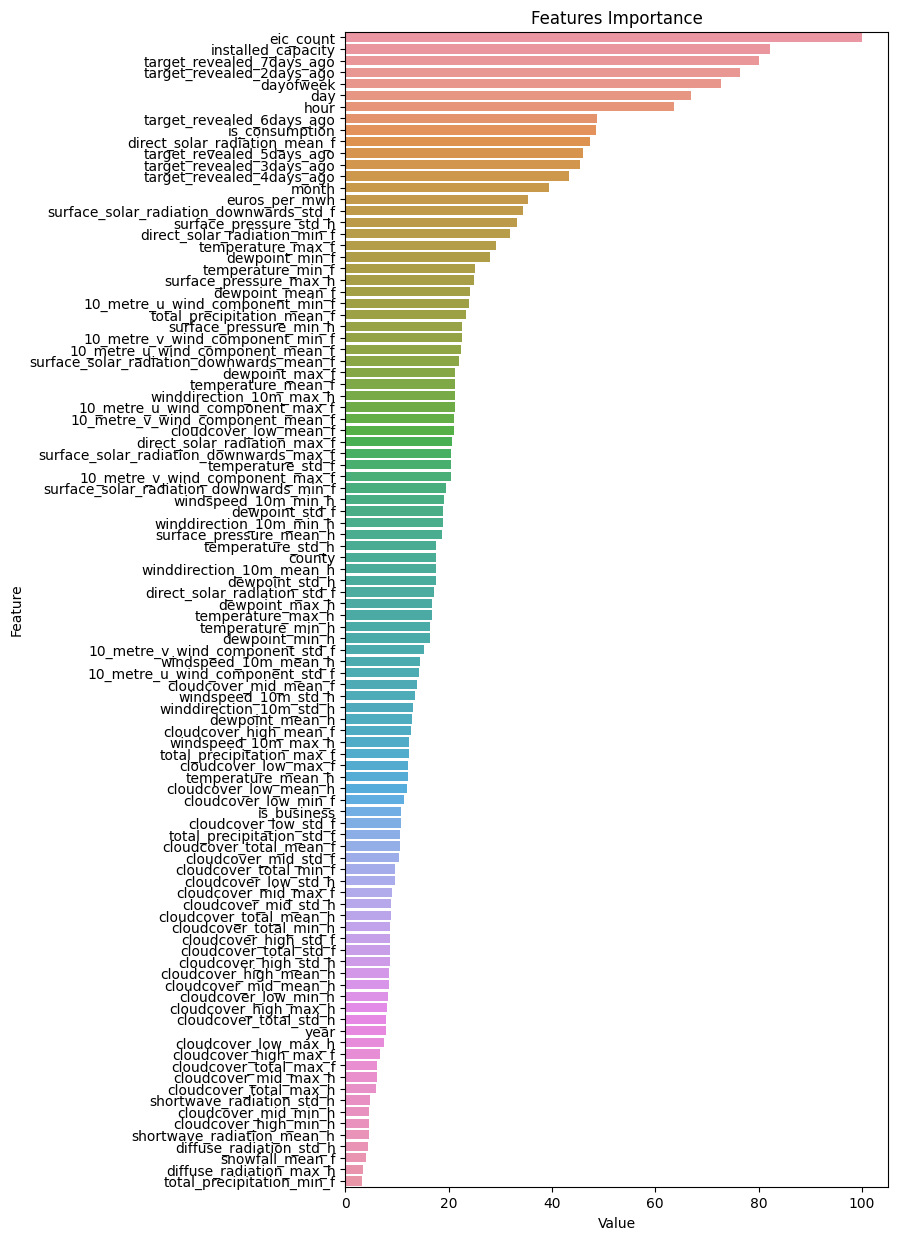

In [43]:
# Features Importance
if len(Feature_Imp) > 90 : plt.figure(figsize=(7, 15))
elif len(Feature_Imp) > 60 : plt.figure(figsize=(7, 12))
elif len(Feature_Imp) > 30 : plt.figure(figsize=(7, 10))
else :
    plt.figure(figsize=(5, 5))
sns.barplot(x="Value", y="Feature", data=Feature_Imp.head(100))
plt.title('Features Importance')
plt.show()

In [44]:
# Most important features
Feature_Imp.Feature.tolist()[:20]

['eic_count',
 'installed_capacity',
 'target_revealed_7days_ago',
 'target_revealed_2days_ago',
 'dayofweek',
 'day',
 'hour',
 'target_revealed_6days_ago',
 'is_consumption',
 'direct_solar_radiation_mean_f',
 'target_revealed_5days_ago',
 'target_revealed_3days_ago',
 'target_revealed_4days_ago',
 'month',
 'euros_per_mwh',
 'surface_solar_radiation_downwards_std_f',
 'surface_pressure_std_h',
 'direct_solar_radiation_min_f',
 'temperature_max_f',
 'dewpoint_min_f']

In [45]:
# Less important features
Feature_Imp.Feature.tolist()[::-1][:10]

['rain_max_h',
 'snowfall_std_h',
 'direct_solar_radiation_max_h',
 'direct_solar_radiation_mean_h',
 'direct_solar_radiation_min_h',
 'direct_solar_radiation_std_h',
 'snowfall_std_f',
 'rain_std_h',
 'snowfall_mean_h',
 'product_type']

In [46]:
import enefit
env = enefit.make_env()
iter_test = env.iter_test()

In [47]:
def add_previous_targets(test, PREVIOUS_TARGET_REVEALED) :
    
    for i, revealed_targets in enumerate(PREVIOUS_TARGET_REVEALED) :
        day_shift = i + 2
    
        # Rename
        revealed_targets = revealed_targets.rename(columns = {"target" : f"target_revealed_{day_shift}days_ago"})

        # Add target 24h ago
        test = pd.merge(test,
                        revealed_targets[["county", "is_business", "product_type", "is_consumption", f"target_revealed_{day_shift}days_ago", "time"]],
                        how = 'left',
                        on = ["county", "is_business", "product_type", "is_consumption", "time"],
                       )
        
    # Fill NaN with last revealed
    for day_shift in range(2, 7) :
        k = f"target_revealed_{day_shift}days_ago"
        if k not in test :
            test[k] = test["target_revealed_2days_ago"].copy()
        else :
            mask = (test[k].isna())
            test.loc[mask, k] = test.loc[mask, "target_revealed_2days_ago"]
        test[k] = test[k].fillna(0.5)

    # Return
    return test


In [48]:
# Reload enefit environment (only in debug mode, otherwise the submission will fail)
if debug :
    enefit.make_env.__called__ = False
    type(env)._state = type(type(env)._state).__dict__['INIT']
    iter_test = env.iter_test()
# -------------------------------------------------------

# List of target_revealed dataframes
PREVIOUS_TARGET_REVEALED = []

# Iterate and submit
for (test, revealed_targets, client,
     historical_weather, forecast_weather,
     electricity_prices, gas_prices, sample_prediction) in iter_test:

    # Rename
    client = client.rename(columns = {'date' : 'datetime'})
    if 'datetime' not in test :
        test   = test.rename(columns = {'prediction_datetime' : 'datetime'})
        
    # Boolean -> Int
    client['is_business'] = client['is_business'].astype(int)
    for k in ['is_business', 'is_consumption'] :
        test[k] = test[k].astype(int)
        revealed_targets[k] = revealed_targets[k].astype(int)
    
    # Date processing + features extraction
    for date_col in ['datetime'] :
        test = process_date(test, date_col, extract_features = True)
        client = process_date(client, date_col)
        historical_weather = process_date(historical_weather, date_col)
        revealed_targets = process_date(revealed_targets, date_col)
    for date_col in ['forecast_date', 'origin_date'] :
        electricity_prices = process_date(electricity_prices, date_col)
        gas_prices = process_date(gas_prices, date_col)
    for date_col in ['forecast_datetime'] :
        forecast_weather = process_date(forecast_weather, date_col)
        
    # Process weather info
    historical_weather = process_weather_info(historical_weather)
    forecast_weather   = process_weather_info(forecast_weather)
    
    # Create df
    test = create_df(test, client, historical_weather, forecast_weather,
                     electricity_prices, gas_prices, sample_prediction)
    
    # Store revealed_targets
    PREVIOUS_TARGET_REVEALED.insert(0, revealed_targets)
    while len(PREVIOUS_TARGET_REVEALED) > 7 :
        PREVIOUS_TARGET_REVEALED.pop()
    
    # Add previous targets
    test = add_previous_targets(test, PREVIOUS_TARGET_REVEALED)
        
    # In case of missing feats, we create them
    missing_feats = [x for x in feats if x not in test]
    if len(missing_feats) > 0 :
        test = pd.concat([test,
                          pd.DataFrame(0, index=np.arange(len(test)), columns=missing_feats)
                         ],
                         axis=1,
                        )

    # Inference
    sample_prediction.drop(columns = ['target'], inplace=True)
    test['target'] = np.clip(model.predict(test[feats]), 0, 15000)
    
    #test['target'] = 0
    #for model in MODELS :
    #    test['target'] += np.clip(model.predict(test[feats]), 0, 15000) / len(MODELS)
        
    # Add target to sample_prediction
    sample_prediction = pd.merge(sample_prediction, test[['row_id', 'target']], on='row_id', how='left')
    
    # Send predictions
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [49]:
# Show sample_prediction
try :
    print(sample_prediction.shape)
    display(sample_prediction.head())
except :
    print("Oops, something went wrong !")

(3120, 2)


,row_id,target
0,2015232,0.53414
1,2015233,392.76944
2,2015234,0.00000
3,2015235,4.40108
4,2015236,20.06441
